# In this notebook, we will first highlight how blip image captioning works and explain the different blocks of the model in order to fully understand how it works.

In [45]:
import torch

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [47]:
import torch

print("GPU name :", torch.cuda.get_device_name(0))
print("Device used :", device)


GPU name : Tesla V100S-PCIE-32GB
Device used : cuda


In [48]:
pip install transformers torch torchvision # packages installation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [49]:
import sys
import numpy as np
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
sys.path.append("../")  
import src.RBM_O as rbm

In [50]:
import cv2
import matplotlib.pyplot as plt

def print_image(image_path):
    """"Cette fonction est permet d'afficher une image située à l'adresse image_path"""
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB

    # Afficher l'image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

We are testing blip-base captioning

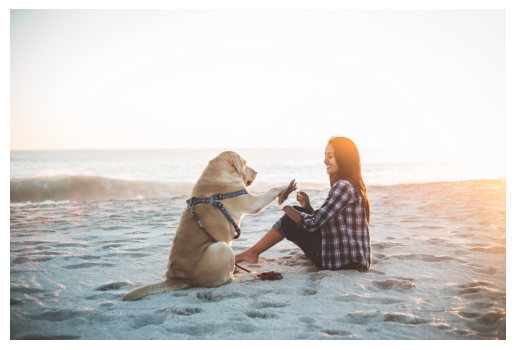

caption : a woman sitting on the beach with her dog


In [51]:
# The modèl and the processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Charge the image 
image_path = "../images/demo_BLIP.jpg"  
image = Image.open(image_path).convert("RGB")

# Image preprocessing 
inputs = processor(image, return_tensors="pt")

# captionning
output = model.generate(**inputs)

# print the image 
print_image("../images/demo_BLIP.jpg")

# decodage 
caption = processor.decode(output[0], skip_special_tokens=True)
print("caption :", caption)


In [52]:
save_directory = "../models_saved/blip-image-captioning-base_local"

model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

[]

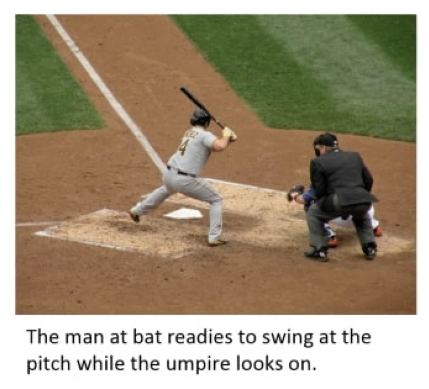

caption : a baseball player swinging at a ball during a game


In [53]:
image_path = "../images/the_battle_man.jpg" 

image = Image.open(image_path).convert("RGB")

print_image("../images/the_battle_man_o.jpg")

inputs = processor(image, return_tensors="pt")

output = model.generate(**inputs)

caption = processor.decode(output[0], skip_special_tokens=True)

print("caption :", caption)

Here we see the difference in description between the two texts. The Blip's description is less rich than the image's. Our approach aims to enrich this description.

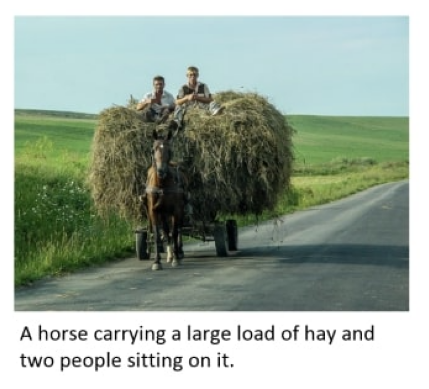

caption : a horse pulling a cart of hay down a country road


In [54]:
image_path = "../images/The_horse_carryer.jpg"  
image = Image.open(image_path).convert("RGB")
print_image("../images/The_horse_carryer_o.jpg")
inputs = processor(image, return_tensors="pt")

output = model.generate(**inputs)

caption = processor.decode(output[0], skip_special_tokens=True)
print("caption :", caption)

The image depicts: a horse carrying a large load of hay and two people sitting on it.

BLIP sees: a horse pulling a hay wagon on a country road.

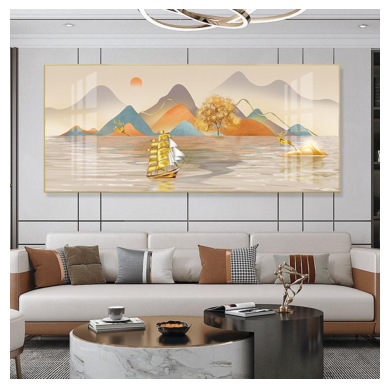

sailing with sailing boat painting abstract painting, canvas painting boat and tree, sail art, colorful seas and the boat is sea painting


In [55]:
print_image("../images/salon_canape_tableau.jpg")
image_path = "../images/salon_canape_tableau.jpg"  
image = Image.open(image_path).convert("RGB")

# Générer la légende de l'image
inputs = processor(images=image, return_tensors="pt")

# Lancer la génération avec les paramètres adaptés
output = model.generate(**inputs, max_length=500, num_beams=5, do_sample=True, temperature=7.0, top_p=0.95)

# Décoder la sortie pour obtenir le texte
caption = processor.decode(output[0], skip_special_tokens=True)
print(caption)

Why not: a living room with a sofa, headphones, two tables, and a large painting on the wall showing a mountain range?

This is the goal of our study. Is it possible, without training the entire model, to improve the description with a Boltzmann machine to decompress the embeddings sent to the decoder and thus obtain a more detailed description of the image?

Let's see what an embedding looks like after encoding the model.

In [56]:
from transformers import BlipProcessor, BlipModel
import torch

# image
image = Image.open("../images/Bink_bed.jpg").convert("RGB")

# image preprocessing
inputs = processor(images=image, return_tensors="pt")

print(inputs)
# image embeddings
with torch.no_grad():
    encoder_outputs = model.vision_model(**inputs).last_hidden_state  # Embeddings

print(encoder_outputs.shape)  # Affiche la dimension des embeddings


{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9157,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [57]:
cls_embedding = encoder_outputs[:, 0, :]  # => shape: [batch_size, 768]
print(cls_embedding.shape) # resume of the visual_embedding

torch.Size([1, 768])


In [58]:
print(inputs["pixel_values"].shape)

torch.Size([1, 3, 384, 384])


It's as if after each image pass in "embeddings" we collect a large tensor of size 577x768 for each image. It's very large as a tensor. It's the digital representation of the image.

Let's take a closer look at what's happening inside each block of the model. But first, let's look at what blocks we have in the model.

In [59]:
# what is in the model ?
for name, module in model.named_children():
    print(name)

vision_model
text_decoder


We see two blocks, vision_model and text_decoder. But let's take a closer loook once again.

In [60]:
for name, module in model.vision_model.named_children():
        print(name)  

embeddings
encoder
post_layernorm


In [61]:
for name, module in model.vision_model.embeddings.named_children():
        print("In embeddings :", name)

for name, module in model.vision_model.encoder.named_children():
        print("In encoder :",name)

for name, module in model.vision_model.post_layernorm.named_children():
        print("In post_layernorm :",name) # this is an empty method, maybe just a metric

In embeddings : patch_embedding
In encoder : layers


In [62]:
# 1. visual Embeddings 
vision_embeddings = model.vision_model.embeddings(inputs["pixel_values"])
print("embeddings shape:", vision_embeddings.shape)

# 2. Encoder
vision_outputs = model.vision_model.encoder(vision_embeddings)
print("encoder output shape:", vision_outputs.last_hidden_state.shape)

# 3. Post-layernorm
post_normed = model.vision_model.post_layernorm(vision_outputs.last_hidden_state)
print("post_layernorm shape:", post_normed.shape)


embeddings shape: torch.Size([1, 577, 768])
encoder output shape: torch.Size([1, 577, 768])
post_layernorm shape: torch.Size([1, 577, 768])


Ok, we notice there is noting inside the post_layernorm (we will see why later)

Inside the embeddings there is a " patch_embedding "

and inside the encoder there is just some layers may be for image embeddings projection in the latent space.

Then let's take a closer look of the decoder

In [63]:
model_decoder = model.text_decoder
for name, module in model_decoder.named_children():
        print(name)

bert
cls


Bert is the decoder used for blip image captions! This is a good thing, as we already know a little about this model…

Next, for better understanding, we'll manually examine what we have after each of these steps.

# What about the decoder

In [64]:
# Define the initial text prompt
prompt = "a photo of"

# Tokenize the text prompt into input IDs (numerical tokens) for the decoder
inputs_text = processor(text=prompt, return_tensors="pt")

# Extract input IDs for the decoder
decoder_input_ids = inputs_text.input_ids

# Run the text decoder (BERT-like) conditioned on the visual features (post_normed)
# - input_ids: tokenized prompt
# - encoder_hidden_states: visual embeddings from the image
# - encoder_attention_mask: attention mask (all ones, since all visual tokens are valid)
outputs = model.text_decoder.bert(
    input_ids=decoder_input_ids,
    encoder_hidden_states=post_normed,
    encoder_attention_mask=torch.ones(post_normed.shape[:-1], dtype=torch.long)
)

# Output shape of the last hidden states from the decoder
print("decoder output shape:", outputs.last_hidden_state.shape)

# Pass the decoder's output through the classification head (cls)
# This head maps the hidden states to vocabulary logits (scores over possible next words)
logits = model.text_decoder.cls(outputs.last_hidden_state)

# Output shape of the logits: [batch_size, sequence_length, vocab_size]
print("cls logits shape:", logits.shape)


decoder output shape: torch.Size([1, 5, 768])
cls logits shape: torch.Size([1, 5, 30524])


### 🔍 Overview of BLIP Model Architecture Components

The BLIP model (`BlipForConditionalGeneration`) consists of two main blocks:

- `vision_model`: Handles image encoding
- `text_decoder`: Handles text decoding and caption generation

Below is a detailed breakdown of the key sub-modules and their roles:

| Module | Role |
|--------|------|
| `vision_model.embeddings` | Converts the input image into visual tokens (patch embeddings) |
| `vision_model.encoder` | Learns deep visual representations using a Vision Transformer (ViT) |
| `vision_model.post_layernorm` | Applies LayerNorm to stabilize and normalize visual features before passing them to the decoder |
| `text_decoder.bert` | A causal language model (BERT-like) that generates text conditioned on image features |
| `text_decoder.cls` | Outputs vocabulary logits for each token position (used for predicting the next word) |


# Now we will explore the contribution of RBM in the Blip image captioning model and then study the results that we observe.

In [65]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
import torch.nn as nn

# image
image = Image.open("../images/the_battle_man.jpg")

# image processing
inputs = processor(images=image, return_tensors="pt")

# patching - visual_embeddings - visual_encoding - layer_norm
visual_features = model.vision_model(**inputs).last_hidden_state
print(visual_features.shape)

torch.Size([1, 577, 768])


In [66]:
max_length = 30
prompt = "a"
inputs_text = processor(text=prompt, return_tensors="pt")
decoder_input_ids = inputs_text.input_ids  # shape: [1, seq_len]
generated_ids = decoder_input_ids  # Commence avec le prompt tokenisé

for _ in range(max_length):
    with torch.no_grad():
        decoder_outputs = model.text_decoder.bert(
            input_ids=generated_ids,
            encoder_hidden_states=visual_features,
            encoder_attention_mask=torch.ones(visual_features.shape[:-1], dtype=torch.long)
        )
        logits = model.text_decoder.cls(decoder_outputs.last_hidden_state)

    # Prendre le dernier token généré
    next_token_logits = logits[:, -1, :]
    next_token_id = torch.argmax(next_token_logits, dim=-1)

    # Si c’est le token de fin, on arrête
    if next_token_id.item() in [processor.tokenizer.sep_token_id, processor.tokenizer.eos_token_id]:
        break

    # Ajouter ce token à la séquence générée
    generated_ids = torch.cat([generated_ids, next_token_id.unsqueeze(0)], dim=1)

# Décodage final
caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated caption:", caption)


Generated caption: a baseball player swinging at a pitch


In [67]:
from datasets import get_dataset_split_names

splits = get_dataset_split_names("phiyodr/coco2017")
print("Splits disponibles :", splits)

Splits disponibles : ['train', 'validation']


In [68]:
from datasets import load_dataset

dataset = load_dataset("phiyodr/coco2017", split="train")
print(f"Nombre d'exemples dans le dataset : {len(dataset)}")

Nombre d'exemples dans le dataset : 118287


In [69]:
print(dataset[0])

{'license': 3, 'file_name': 'train2017/000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'image_id': 391895, 'ids': [770337, 771687, 772707, 776154, 781998], 'captions': ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']}


In [70]:
# Charge tout le split train
dataset = load_dataset("phiyodr/coco2017", split="train")

# Crée un split 90% train / 10% test (modifie test_size si tu veux)
split = dataset.train_test_split(test_size=0.1, seed=42)  # seed pour la reproductibilité

train_set = split["train"]
test_set = split["test"]

print(f"Train : {len(train_set)} exemples")
print(f"Test  : {len(test_set)} exemples")


Train : 106458 exemples
Test  : 11829 exemples


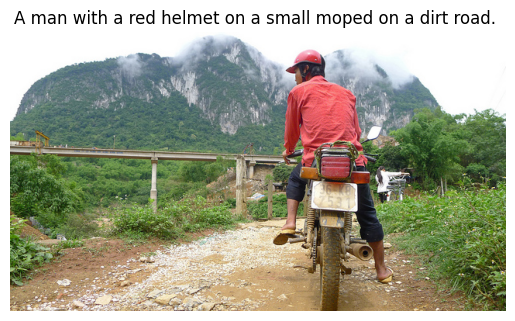

In [71]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# a small set of data just for varification
batch = dataset[:1]

# images and captions
for i in range(len(batch["coco_url"])):
    # image's adress
    img_url = batch["coco_url"][i]
    
    # image the image
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content))
    
    # get captions
    captions = batch["captions"][i]
    
    # images with the first captions
    plt.imshow(image)
    plt.title(captions[0])  # first caption
    plt.axis('off')
    plt.show()


In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [73]:
def download_image(url):
    try:
        img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
        return img
    except:
        return None

def process_batch_both_embeddings(images, processor, model):
    inputs = processor(images=images, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.vision_model(pixel_values=inputs["pixel_values"])
        embeddings = outputs.last_hidden_state  # [B, 577, 768]

        cls_embeddings = embeddings[:, 0, :]      # [B, 768]
        patch_embeddings = embeddings[:, 1:, :]   # [B, 576, 768]
        patch_embeddings = patch_embeddings.reshape(1, -1, embeddings.shape[-1])


        return cls_embeddings, patch_embeddings


In [74]:
from concurrent.futures import ThreadPoolExecutor

def batch_all_embeddings(batch, processor, model, batch_size=32):
    urls = batch["coco_url"]

    with ThreadPoolExecutor(max_workers=8) as executor:
        all_images = list(executor.map(download_image, urls))

    all_images = [img for img in all_images if img is not None]
    print(f"{len(all_images)} images valides sur {len(urls)}")

    all_cls_embeddings = []
    all_patch_embeddings = []

    for i in range(0, len(all_images), batch_size):
        images_batch = all_images[i:i + batch_size]
        cls_emb, patch_emb = process_batch_both_embeddings(images_batch, processor, model)
        all_cls_embeddings.append(cls_emb)
        all_patch_embeddings.append(patch_emb)

    # Concaténer les résultats
    final_cls_embeddings = torch.cat(all_cls_embeddings, dim=0)    # [N, 768]
    final_patch_embeddings = torch.cat(all_patch_embeddings, dim=1)  # [1, N*576, 768]

    print("Shape CLS     :", final_cls_embeddings.shape)
    print("Shape PATCHES :", final_patch_embeddings.shape)

    return final_cls_embeddings, final_patch_embeddings


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch = train_set[:10]
cls_embs, patch_embs = batch_all_embeddings(batch, processor, model, batch_size=32)

# Optionnel : squeeze
patch_embs = patch_embs.squeeze(0)  # [N*576, 768]
print(cls_embs.size())
print(patch_embs.size())


10 images valides sur 10
Shape CLS     : torch.Size([10, 768])
Shape PATCHES : torch.Size([1, 5760, 768])
torch.Size([10, 768])
torch.Size([5760, 768])


In [76]:
visible_dim = 768
hidden_dim = 2000
sigma = 10

RBM_patch =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)

RBM_cls =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)

In [77]:
print(RBM_patch)

GaussianBinaryRBM()


In [78]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Epoch 1/120 | Température: 0.0000 | Énergie moyenne: -115114.8846
Epoch 2/120 | Température: 0.0000 | Énergie moyenne: -406751.9851
Epoch 3/120 | Température: 5832.7390 | Énergie moyenne: -455184.5762
Epoch 4/120 | Température: 27072.2565 | Énergie moyenne: -455382.9484
Epoch 5/120 | Température: 3692.6894 | Énergie moyenne: -548063.5119
Epoch 6/120 | Température: 17139.3639 | Énergie moyenne: -627933.4414
Epoch 7/120 | Température: 2337.8305 | Énergie moyenne: -731442.1847
Epoch 8/120 | Température: 10850.8796 | Énergie moyenne: -821700.1807
Epoch 9/120 | Température: 8633.7618 | Énergie moyenne: -915638.3716
Epoch 10/120 | Température: 40073.0114 | Énergie moyenne: -988318.2919
Epoch 11/120 | Température: 5466.0086 | Énergie moyenne: -1094899.4980
Epoch 12/120 | Température: 25370.1026 | Énergie moyenne: -1183767.0371
Epoch 13/120 | Température: 3460.5135 | Énergie moyenne: -1276940.8527
Epoch 14/120 | Température: 16061.7354 | Énergie moyenne: -1360406.5635
Epoch 15/120 | Températur

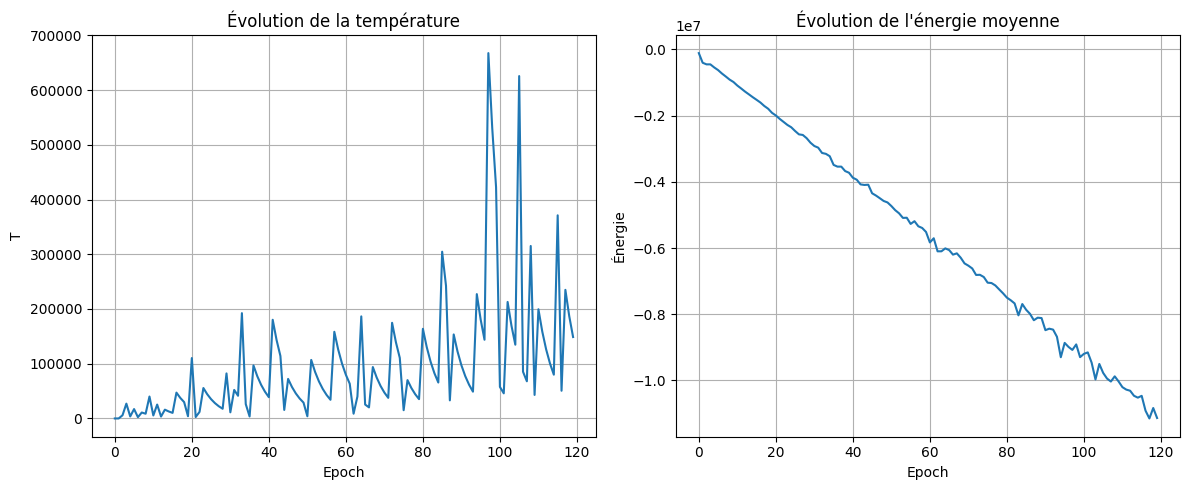

In [79]:
RBM_patch.train(patch_embs, batch_size=5, epochs=120)


In [80]:
#RBM_cls.train(cls_embs, batch_size=30, epochs = 300)

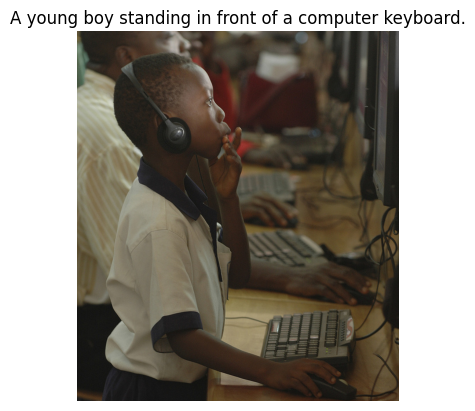

In [97]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Prendre l'image et les captions à l'index 800
test_image = dataset[3]

# Récupérer l'URL de l'image
img_url = test_image["coco_url"]

# Télécharger l'image
response = requests.get(img_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Récupérer les légendes
captions = test_image["captions"]

# Afficher l'image avec sa première légende
plt.imshow(image)
plt.title(captions[0])
plt.axis('off')
plt.show()


In [106]:
# Charger l'image
img_url = dataset[3]["coco_url"]
image = Image.open(BytesIO(requests.get(img_url).content)).convert("RGB")

# Préparer l'image pour BLIP
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Passer par l'encodeur visuel
with torch.no_grad():
    vision_outputs = model.vision_model(pixel_values=inputs["pixel_values"])
    embeddings = vision_outputs.last_hidden_state
    print(embeddings.size())
    cls_embedding_t = embeddings[:, 0, :]  # [CLS] token
    

torch.Size([1, 577, 768])


In [107]:
# embeddings a une shape [1, 577, 768] → 1 batch, 577 tokens (1 CLS + 576 patches), 768 dim
patch_embeddings_t = embeddings[:, 1:, :]         # shape [1, 576, 768]
patch_embeddings = patch_embeddings_t.squeeze(0)  # shape [576, 768]

cls_embedding_t = embeddings[:, 0, :]             # shape [1, 768]
print(patch_embeddings.size())
print(cls_embedding.size())

torch.Size([576, 768])
torch.Size([1, 768])


In [108]:
# patch_embeddings: [576, 768]
patch_embeddings = patch_embeddings.to(RBM_patch.device)

# Reconstruction par la RBM
# Correct et propre :
new_patch_embeddings = RBM_patch.forward(patch_embeddings, iter=1)


print(new_patch_embeddings.shape)  # [576, 768]


torch.Size([576, 768])


In [109]:
# S'assurer que les dimensions sont bonnes
new_patch_embeddings = new_patch_embeddings.unsqueeze(0)  # [1, 576, 768]
#new_cls_embeddings = new_cls_embeddings.unsqueeze(1)      # [1, 1, 768]

cls_token = embeddings[:, 0, :].unsqueeze(1)  # shape: [1, 1, 768]
generated_embeddings = torch.cat([cls_token, new_patch_embeddings], dim=1)  # shape: [1, 577, 768]


In [110]:
max_length = 10
prompt = "A young"

# Tokenisation sur le bon device
inputs_text = processor(text=prompt, return_tensors="pt").to(model.device)
decoder_input_ids = inputs_text.input_ids  # [1, seq_len]
generated_ids = decoder_input_ids.clone()

# Attention mask pour l'encodeur
attention_mask = torch.ones(embeddings.shape[:-1], dtype=torch.long).to(model.device)

for _ in range(max_length):
    with torch.no_grad():
        decoder_outputs = model.text_decoder.bert(
            input_ids=generated_ids,
            encoder_hidden_states=embeddings,
            encoder_attention_mask=attention_mask
        )
        logits = model.text_decoder.cls(decoder_outputs.last_hidden_state)

    next_token_logits = logits[:, -1, :]  # [1, vocab_size]
    next_token_id = torch.argmax(next_token_logits, dim=-1)  # [1]

    if next_token_id.item() in [processor.tokenizer.sep_token_id, processor.tokenizer.eos_token_id]:
        break

    next_token_id = next_token_id.unsqueeze(1)  # [1, 1]
    generated_ids = torch.cat([generated_ids, next_token_id], dim=1)

caption = processor.tokenizer.decode(
    generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
)

print("Generated caption:", caption)


Generated caption: a young


In [111]:
max_length = 10
prompt = "A young"

# Tokenisation sur le bon device
inputs_text = processor(text=prompt, return_tensors="pt").to(model.device)
decoder_input_ids = inputs_text.input_ids  # [1, seq_len]
generated_ids = decoder_input_ids.clone()

# Attention mask pour l'encodeur
attention_mask = torch.ones(generated_embeddings.shape[:-1], dtype=torch.long).to(model.device)

for _ in range(max_length):
    with torch.no_grad():
        decoder_outputs = model.text_decoder.bert(
            input_ids=generated_ids,
            encoder_hidden_states=generated_embeddings,
            encoder_attention_mask=attention_mask
        )
        logits = model.text_decoder.cls(decoder_outputs.last_hidden_state)

    next_token_logits = logits[:, -1, :]  # [1, vocab_size]
    next_token_id = torch.argmax(next_token_logits, dim=-1)  # [1]

    if next_token_id.item() in [processor.tokenizer.sep_token_id, processor.tokenizer.eos_token_id]:
        break

    next_token_id = next_token_id.unsqueeze(1)  # [1, 1]
    generated_ids = torch.cat([generated_ids, next_token_id], dim=1)

caption = processor.tokenizer.decode(
    generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
)

print("Generated caption:", caption)


Generated caption: a young the the the the a a a a a a
